# Processing Many Exposures to Make a Light Curve

In the last tutorial, you learned how to measure the calibrated magnitude of a target source in a single exposure.

In this tutorial, you will now do this measurement of a target source in many exposures. If you plot the measured calibrated magnitudes over time, this is called a light curve. In this tutorial, you will do exactly this! 

In the last tutorial, you also learned how to make a cutout image of the target source. In this tutorial, you will make a cutout of the target source in many exposures and stitch it togehter to make a gif to see how it changes over time. 

This notebook requires installing the following Python modules. This should be set up already on the google co-lab platform. 
* pip install photutils
* pip install astropy
* pip install imageio

In [21]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np

from photutils import Background2D, SExtractorBackground
from photutils import DAOStarFinder
from photutils import CircularAperture,aperture_photometry
from photutils.utils import calc_total_error

import astropy.wcs as wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.nddata.utils import Cutout2D
from astropy import units as u

import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

# 0. Define Functions 
1. To get photometry that you will use in this Jupyter notebook
2. To create a cutout image around a given RA and DEC

To get more explanations on these two functions, you can go over the Student_Workbook_1_SingleExposure again.

In [29]:
# A function that outputs the magnitude of a source, and its error.

def do_phot_get_mag(data,hdr,err,ra,dec):
    zpt_instrumental = 25.
    w         = wcs.WCS(hdr)
    xcoords, ycoords = w.all_world2pix(ra,dec,1)
    positions = np.transpose((xcoords, ycoords))
    apertures = CircularAperture(positions, r=24.)
    phot      = aperture_photometry(data, apertures, error=err)

    mag     = list(-2.5*np.log10(phot['aperture_sum']) + zpt_instrumental)
    mag_err = list((2.5/np.log(10))*(phot['aperture_sum_err']/phot['aperture_sum']))
    
    return mag,mag_err


# A function that outputs a small cutout of an image given a big image. 

def make_cutout(data,hdr,ra,dec):

    w = wcs.WCS(hdr)
    xcoord, ycoord = w.all_world2pix(ra,dec,1)
    position = np.transpose((xcoord, ycoord))
    size = u.Quantity([120, 120], u.pixel)
    cutout = Cutout2D(data, position, size, wcs=w, mode='strict')

    cutout_wcs = cutout.wcs
    header = cutout_wcs.to_header()
    hdu = fits.PrimaryHDU(data=cutout.data, header=header)

    return hdu

# 1. Find all exposures

In [6]:
# Set path to file
# This exposure was taken in the B-band. 
mypath       = '../../../Data/Target_F/V/' 
outmoviename = 'mymovie.gif'

In [7]:
# Load in all of the fits images in the directory and sort it

image_list = glob.glob(mypath+'*e91.fits.fz')
image_list.sort()
print(image_list)

['../../../Data/Target_F/V/cpt0m407-kb84-20191029-0082-e91.fits.fz', '../../../Data/Target_F/V/cpt0m407-kb84-20191029-0084-e91.fits.fz', '../../../Data/Target_F/V/cpt0m407-kb84-20191029-0090-e91.fits.fz', '../../../Data/Target_F/V/cpt0m407-kb84-20191029-0097-e91.fits.fz', '../../../Data/Target_F/V/cpt0m407-kb84-20191029-0105-e91.fits.fz', '../../../Data/Target_F/V/cpt0m407-kb84-20191029-0109-e91.fits.fz', '../../../Data/Target_F/V/cpt0m407-kb84-20191029-0112-e91.fits.fz', '../../../Data/Target_F/V/cpt0m407-kb84-20191029-0114-e91.fits.fz', '../../../Data/Target_F/V/cpt0m407-kb84-20191029-0127-e91.fits.fz', '../../../Data/Target_F/V/cpt0m407-kb84-20191029-0137-e91.fits.fz', '../../../Data/Target_F/V/cpt0m407-kb84-20191029-0152-e91.fits.fz', '../../../Data/Target_F/V/cpt0m407-kb84-20191029-0173-e91.fits.fz', '../../../Data/Target_F/V/cpt0m407-kb84-20191029-0188-e91.fits.fz', '../../../Data/Target_F/V/lsc0m412-kb26-20191029-0075-e91.fits.fz']


### Exercise

In [8]:
# Print the number of files

print(len(image_list))

14


# 2. Input RA and DEC of Target and Reference Stars

In [23]:
# Identify the star that you wanted to observe by opening the image in ds9 
# by finding the star with the matching RA and DEC
# Write down the RA and DEC of your target star here
# Check that the star is not saturated.

# This is not a fake target star, this target is actually a variable source! 
# You will see that it's calibrated magnitude varies with time in the below light curve you will learn to make.

target_RA  = 42.54127
target_DEC = -26.26448

In [10]:
# By looking at one of the exposures in ds9, identify 4-8 round, 
# bright stars that are not saturated 
# to use as ref stars.
# Write down their RA, DEC below in a list

ref_ra  = [42.511006, 42.516465, 42.529286,  42.570479,  42.607145]
ref_dec = [-26.234616,-26.204686,-26.250919, -26.411994,-26.369884]

In [11]:
# Download the APASS catalog of this region of the sky from here: 
# https://www.aavso.org/apass-dr10-download
# Identify which sources on the APASS catalog match the RA and DEC of your selected reference stars
# Write down the magnitude of your selected reference stars below in a list

ref_mag= [12.122,11.815,12.504,12.198,13.299]

## Exercise / Question

Why do you think we use several reference stars instead of one? Write all the reasons you can think of.

In [24]:
# Type up answers here as comments. 


# 3. Visualize the first image in the list of images, target and refernece stars

vmin:  -57.692394
vmax:  60.759827


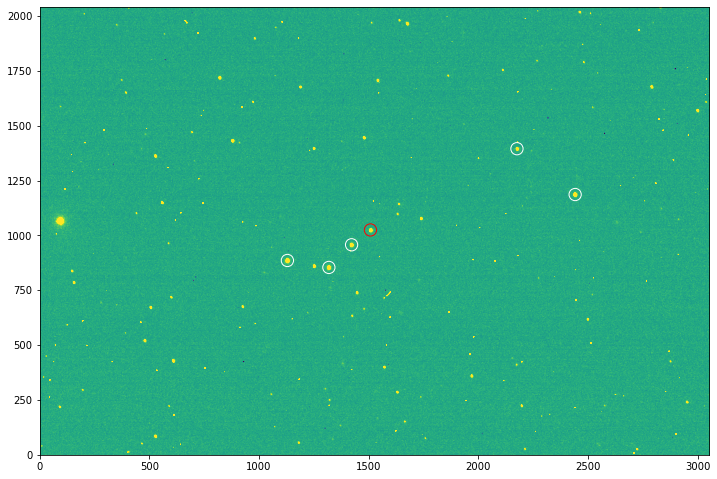

In [27]:
# Plot the whole image with the reference star and target star marked to see if it all looks ok

# Read in the data
sci_data, sci_hdr   = fits.getdata(image_list[0],header=True)

# Get the World Coordinate System (WCS) from the fits header. 
w                            = wcs.WCS(sci_hdr)

# Determine where to mark the reference stars in image coordinaes
xcoord_ref, ycoord_ref       = w.all_world2pix(ref_ra,ref_dec,1)
xcoord_target, ycoord_target = w.all_world2pix([target_RA],[target_DEC],1)

# Get the best vmin and vmax to visualize the image
interval = ZScaleInterval()
vmin     = interval.get_limits(sci_data)[0]
vmax     = interval.get_limits(sci_data)[1]
print('vmin: ',vmin)
print('vmax: ',vmax)

# Plot the figure
figure = plt.figure(figsize=(12,24))
plt.imshow(sci_data, vmin=vmin, vmax=vmax, origin='lower')

# Mark with a red circle the target stars. 
plt.scatter(xcoord_target,ycoord_target,marker='o',
            facecolors='none',s=150,linewidth=1,color='red')

# Mark with white circles the reference stars. 
plt.scatter(xcoord_ref,ycoord_ref,marker='o',
            facecolors='none',s=150,linewidth=1,color='white')

# 4. Calculate the magnitude of the target star in all B-band frames

In [33]:
# Make some useful lists of values to track/record

obstime = [] # Time needed for x-axis 
Bmag    = [] # magnitude needed for y-axis
Bmag_e  = [] # magnitude error needed for y value error bar

# Loop through each frame and calculate and save the required values

for frame in image_list:
    # 1. Open the frame and read out the data, header and time of observation
    sci_data, sci_hdr   = fits.getdata(frame,header=True)
    time = sci_hdr['MJD-OBS']
    
    # Record the time of observation of this frame
    obstime.append(time)
    
    # 2. Get the background of the image and subtract it; 
    # Calculate the error associated with the background.
    sigma_clip = SigmaClip(sigma=3.) # Sigma clip bright obvious things to avoid biasing the background estimate
    bkg_estimator = SExtractorBackground() # Apply the SExtractor algorithm to our estimation
    bkg = Background2D(
        sci_data, (50, 50),
        filter_size=(3, 3),
        sigma_clip=sigma_clip,
        bkg_estimator=bkg_estimator)

    # Now let's subtract the background from the data
    sci_bkg = sci_data - bkg.background

    # Define an error image that will be used when calculating photometry
    effective_gain = 1.
    error = calc_total_error(sci_bkg, bkg.background_rms, effective_gain)
    
    # 3. For the target star and each reference star, carry out photometry. 
    # Be sure to use the background subtracted image. 
    # This step should output an error of the photmetry measurement. 
    
    # Calculate instrumental mags for each of the reference stars
    ref_instr_mag,ref_instr_mag_err = do_phot_get_mag(sci_bkg,sci_hdr,error,ref_ra,ref_dec)

    # Do photometry on the variable target
    tar_mag,tar_mag_err = do_phot_get_mag(sci_bkg,sci_hdr,error,target_RA,target_DEC)
    
    # 4. Find the magnitude offset between the reference stars 
    # and the catalog magnitudes 
    # and calculate the magnitude of the target star, and its error. 
    
    # Calculate offsets and the standard deviation of the offset from each star.
    offsets = []
    for i in range(len(ref_instr_mag)):
        offsets.append(ref_mag[i] - ref_instr_mag[i])
    offset = np.mean(offsets)
    offset_err = np.std(offsets)

    cal_tar_mag = tar_mag[0]+offset
    cal_tar_mag_err = np.sqrt(tar_mag_err[0]**2.+offset_err**2.)
    
    Bmag.append(cal_tar_mag)
    Bmag_e.append(cal_tar_mag_err)

KeyboardInterrupt: 

### Excercise

In [ ]:
# Print the B magnitude (Bmag), observation time (obstime), and B magnitude error (Bmag_e)

print(Bmag)
print(obstime)
print(Bmag_e)

# Make a light curve

In [ ]:
# # Make a rudimentary lightcurve

plt.figure(figsize=(10.5, 7))
plt.errorbar(obstime,Bmag,xerr=None,yerr=Bmag_e, fmt='mo', capsize=9.0)
plt.xlabel('MJD', fontsize=18)
plt.ylabel('B Magnitude', fontsize=18)
plt.show()

# Make a tiny cutout around the star for each exposure and make it into a movie

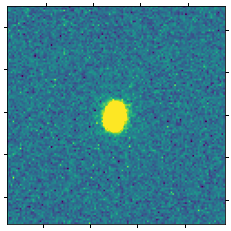

In [18]:
#Make some useful lists of values to track/record

obstime = []
Bmag = []
Bmag_e = []

# Loop through each frame and calculate and save the required values

for frame in image_list:
    # 1. Open the frame and read out the data, header and time of observation
    # Read in file
    hdu = fits.open(frame)

    # Grab the actual science data based on above.
    sci_data = hdu[1]
    sci_hdr = sci_data.header
    time = sci_hdr['MJD-OBS']
    
    # Record the time of observation of this frame
    obstime.append(time)
    
    # 2. Get the background of the image and subtract it; 
    # Calculate the error associated with the background.
    sigma_clip = SigmaClip(sigma=3.) # Sigma clip bright obvious things to avoid biasing the background estimate
    bkg_estimator = SExtractorBackground() # Apply the SExtractor algorithm to our estimation
    bkg = Background2D(
        sci_data.data, (50, 50),
        filter_size=(3, 3),
        sigma_clip=sigma_clip,
        bkg_estimator=bkg_estimator)

    # Now let's subtract the background from the data
    sci_bkg = sci_data.data - bkg.background

    # Define an error image that will be used when calculating photometry
    effective_gain = 1.
    error = calc_total_error(sci_bkg, bkg.background_rms, effective_gain)
    
    # 3. For the target star and each reference star, carry out photometry. 
    # Be sure to use the background subtracted image. 
    # This step should output an error of the photmetry measurement. 
    
    # Calculate instrumental mags for each of the reference stars
    ref_instr_mag,ref_instr_mag_err = do_phot_get_mag(sci_bkg,sci_hdr,error,ref_ra,ref_dec)

    # Make tiny cutouts of the variable star in each frame
    cutout_hdu = make_cutout(sci_bkg,sci_hdr,target_RA,target_DEC)
    #cutout_hdu.writeto(frame+'_cutout.fits', overwrite=True)

    # Plot figures using these cutouts and output images
    interval = ZScaleInterval()
    vmin = interval.get_limits(cutout_hdu.data)[0]
    vmax = interval.get_limits(cutout_hdu.data)[1]

    plt.subplot(projection=wcs.WCS(cutout_hdu.header))
    plt.imshow(cutout_hdu.data, vmin=vmin, vmax=vmax, origin='lower')
    plt.xlabel('R.A.')
    plt.ylabel('Declination')

    # Save the small cutout as a png, with the file name as the time of observation. 
    # This can be used later to make a movie of your source
    pngname = str(time).replace('.','')
    plt.savefig(mypath+pngname+'.png', overwrite=True)

### Make small cutouts into a movie

In [19]:
# Here we are going to use the cutouts we made above to make
# an little movie of the variable star target changing brightness
# over time and loop it!

import imageio 

cutout_list = glob.glob(mypath+'*.png')
cutout_list.sort()

cutout_frames = []
for file in cutout_list:
    cutout_frames.append(imageio.imread(file))
imageio.mimsave(mypath+'mymovie.gif', cutout_frames)